This kernel implements 4 DL models for coreference resolution. All the model in this kernel are Non-RNN Based DL models.

Features extraction used in this kernel follows Clark and Mannings work: https://nlp.stanford.edu/pubs/clark2016improving.pdf
If you are interested in RNN based End2End coreference solution model, please check this kernel: https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.t

['gap-coreference', 'fasttext-crawl-300d-2m', 'gendered-pronoun-resolution']


In [2]:
DATA_ROOT = '../input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-coreference')
SUB_DATA_FOLDER = os.path.join(DATA_ROOT, 'gendered-pronoun-resolution')
FAST_TEXT_DATA_FOLDER = os.path.join(DATA_ROOT, 'fasttext-crawl-300d-2m')

# Import Data

In [7]:
test_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-test.tsv')
train_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-development.tsv')
dev_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-validation.tsv')
sub_test_df_path = os.path.join(SUB_DATA_FOLDER, 'test_stage_2.tsv')

train_df = pd.read_csv(train_df_path, sep='\t')
test_df = pd.read_csv(test_df_path, sep='\t')
dev_df = pd.read_csv(dev_df_path, sep='\t')
sub_test_df = pd.read_csv(sub_test_df_path, sep='\t')

#pd.options.display.max_colwidth = 1000

In [4]:
train_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,test-1,Upon their acceptance into the Kontinental Hoc...,His,383,Bob Suter,352,False,Dehner,366,True,http://en.wikipedia.org/wiki/Jeremy_Dehner
1,test-2,"Between the years 1979-1981, River won four lo...",him,430,Alonso,353,True,Alfredo Di St*fano,390,False,http://en.wikipedia.org/wiki/Norberto_Alonso
2,test-3,Though his emigration from the country has aff...,He,312,Ali Aladhadh,256,True,Saddam,295,False,http://en.wikipedia.org/wiki/Aladhadh
3,test-4,"At the trial, Pisciotta said: ``Those who have...",his,526,Alliata,377,False,Pisciotta,536,True,http://en.wikipedia.org/wiki/Gaspare_Pisciotta
4,test-5,It is about a pair of United States Navy shore...,his,406,Eddie,421,True,Rock Reilly,559,False,http://en.wikipedia.org/wiki/Chasers


# Explore Features for Building Mention-Pair Distributed Representation

## Embedding Features

Follow the idea from the work by Clark and Manning, extract word embedding of head word, dependency parent, first word, last word, two preceding words and two following words of the mention.  Average word embeding of the five preceding words, five following words, all words in the mention, all words in the sentences.

### Parse Text

In [8]:
from spacy.lang.en import English
from spacy.pipeline import DependencyParser
import spacy
from nltk import Tree

In [9]:
nlp = spacy.load('en_core_web_lg')

# build a tree
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_
# binary search for a target_
def bs(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid + 1
    return lo

# get k preceding words starting from offest
def _get_preceding_words(tokens, offset, k):
    start = offset - k
    
    precedings = [None] * max(0, 0-start)
    start = max(0, start)
    precedings += tokens[start: offset]
    
    return precedings

# get k following words starting from offest
def _get_following_words(tokens, offset, k):
    end = offset + k
    
    followings = [None] * max(0, end - len(tokens))
    end = min(len(tokens), end)
    followings += tokens[offset: end]
    
    return followings
        

def extrac_embed_features_tokens(text, char_offset):
    doc = nlp(text)
    
    # char offset to token offset
    lens = [token.idx for token in doc] # list if indices of the start of each token in the doc 
    mention_offset = bs(lens, char_offset) - 1
    # mention_word
    mention = doc[mention_offset]
    
    # token offset to sentence offset
    lens = [len(sent) for sent in doc.sents]
    acc_lens = [len_ for len_ in lens]
    pre_len = 0
    for i in range(0, len(acc_lens)):
        pre_len += acc_lens[i]
        acc_lens[i] = pre_len
    sent_index = bs(acc_lens, mention_offset)
    # mention sentence
    sent = list(doc.sents)[sent_index]
    
    # dependency parent
    head = mention.head
    
    # last word and first word
    first_word, last_word = sent[0], sent[-2]
    
    assert mention_offset >= 0
    
    # two preceding words and two following words
    tokens = list(doc)
    precedings2 = _get_preceding_words(tokens, mention_offset, 2)
    followings2 = _get_following_words(tokens, mention_offset, 2)
    
    # five preceding words and five following words
    precedings5 = _get_preceding_words(tokens, mention_offset, 5)
    followings5 = _get_following_words(tokens, mention_offset, 5)
    
    # sentence words
    sent_tokens = [token for token in sent]
    
    return mention, head, first_word, last_word, precedings2, followings2, precedings5, followings5, sent_tokens

Example:

In [10]:
print("Texts: ")
text = u"Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline."
print(text)

print("\nDependency parsing trees: ")
doc = nlp(text)
[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

print("\nFeatures:")
mention, parent, first_word, last_word, precedings2, followings2, precedings5, followings5, sent_tokens = extrac_embed_features_tokens(text, 274)
features = pd.Series([str(feature) for feature in (mention, parent, first_word, last_word, precedings2, followings2, precedings5, followings5, sent_tokens)], index=['mention', 'parent', 'first_word', 'last_word', 'precedings2', 'followings2', 'precedings5', 'followings5', 'sent_tokens'])
features

Texts: 
Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.

Dependency parsing trees: 
                    played                            
  ____________________|________                        
 |         |               girlfriend                 
 |         |           ________|____________           
 |         |          |        |            of        
 |         |          |        |            |          
 |      Telford       |     officer       Simon       
 |    _____|_____     |        |        ____|_____     
 .  Zoe          --  the     police    ,        Maggie

                                 Dump

mention                                                      her
parent                                                 boyfriend
first_word                                                Dumped
last_word                                                Pauline
precedings2                                          [., Dumped]
followings2                                     [her, boyfriend]
precedings5                        [Simon, 's, class, ., Dumped]
followings5               [her, boyfriend, following, Simon, 's]
sent_tokens    [Dumped, her, boyfriend, following, Simon, 's,...
dtype: object

### Generate Embedding Features

In [18]:
num_embed_features = 11
embed_dim = 300

In [19]:
def create_embedding_features(df, text_column, offset_column):
    text_offset_list = df[[text_column, offset_column]].values.tolist()
    num_features = num_embed_features
    
    embed_feature_matrix = np.zeros(shape=(len(text_offset_list), num_features, embed_dim))
    for text_offset_index in range(len(text_offset_list)):
        text_offset = text_offset_list[text_offset_index]
        mention, parent, first_word, last_word, precedings2, followings2, precedings5, followings5, sent_tokens = extrac_embed_features_tokens(text_offset[0], text_offset[1])
        
        feature_index = 0
        embed_feature_matrix[text_offset_index, feature_index, :] = mention.vector
        feature_index += 1
        embed_feature_matrix[text_offset_index, feature_index, :] = parent.vector
        feature_index += 1
        embed_feature_matrix[text_offset_index, feature_index, :] = first_word.vector
        feature_index += 1
        embed_feature_matrix[text_offset_index, feature_index, :] = last_word.vector
        feature_index += 1
        embed_feature_matrix[text_offset_index, feature_index:feature_index+2, :] = np.asarray([token.vector if token is not None else np.zeros((embed_dim,)) for token in precedings2])
        feature_index += len(precedings2)
        embed_feature_matrix[text_offset_index, feature_index:feature_index+2, :] = np.asarray([token.vector if token is not None else np.zeros((embed_dim,)) for token in followings2])
        feature_index += len(followings2)
        embed_feature_matrix[text_offset_index, feature_index, :] = np.mean(np.asarray([token.vector if token is not None else np.zeros((embed_dim,)) for token in precedings5]), axis=0)
        feature_index += 1
        embed_feature_matrix[text_offset_index, feature_index, :] = np.mean(np.asarray([token.vector if token is not None else np.zeros((embed_dim,)) for token in followings5]), axis=0)
        feature_index += 1
        embed_feature_matrix[text_offset_index, feature_index, :] = np.mean(np.asarray([token.vector for token in sent_tokens]), axis=0) if len(sent_tokens) > 0 else np.zeros(embed_dim)
        feature_index += 1
    
    return embed_feature_matrix

 ##  Position Features

Encode the absolute positions in the sentence and the relative position between the pronoun and the entities.

In [20]:
def bs_(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid
    return lo

# one hot encoding distance
def ohe_dist(dist, buckets):
    idx = bs_(buckets, dist)
    oh = np.zeros(shape=(len(buckets),), dtype=np.float32)
    oh[idx] = 1
    
    return oh

In [21]:
def extrac_positional_features(text, char_offset1, char_offset2):
    doc = nlp(text)
    max_len = 64
    
    # char offset to token offset
    lens = [token.idx for token in doc]
    mention_offset1 = bs(lens, char_offset1) - 1
    mention_offset2 = bs(lens, char_offset2) - 1
    
    # token offset to sentence offset
    lens = [len(sent) for sent in doc.sents]
    acc_lens = [len_ for len_ in lens]
    pre_len = 0
    for i in range(0, len(acc_lens)):
        pre_len += acc_lens[i]
        acc_lens[i] = pre_len
    sent_index1 = bs(acc_lens, mention_offset1)
    sent_index2 = bs(acc_lens, mention_offset2)
    
    sent1 = list(doc.sents)[sent_index1]
    sent2 = list(doc.sents)[sent_index2]
    
    # buckets
    bucket_dist = [1, 2, 3, 4, 5, 8, 16, 32, 64]
    
    # relative distance
    dist = mention_offset2 - mention_offset1
    dist_oh = ohe_dist(dist, bucket_dist)
    
    # buckets
    bucket_pos = [0, 1, 2, 3, 4, 5, 8, 16, 32]
    
    # absolute position in the sentence
    # position of the first mention from both sides of the sentence
    sent_pos1 = mention_offset1 + 1
    if sent_index1 > 0:
        sent_pos1 = mention_offset1 - acc_lens[sent_index1-1]
    sent_pos_oh1 = ohe_dist(sent_pos1, bucket_pos)
    sent_pos_inv1 = len(sent1) - sent_pos1
    assert sent_pos_inv1 >= 0
    sent_pos_inv_oh1 = ohe_dist(sent_pos_inv1, bucket_pos)
    
    # position of the second mention from both sides of the sentence
    sent_pos2 = mention_offset2 + 1
    if sent_index2 > 0:
        sent_pos2 = mention_offset2 - acc_lens[sent_index2-1]
    sent_pos_oh2 = ohe_dist(sent_pos2, bucket_pos)
    sent_pos_inv2 = len(sent2) - sent_pos2
    if sent_pos_inv2 < 0:
        print(sent_pos_inv2)
        print(len(sent2))
        print(sent_pos2)
        raise ValueError
    sent_pos_inv_oh2 = ohe_dist(sent_pos_inv2, bucket_pos)
    
    sent_pos_ratio1 = sent_pos1 / len(sent1)
    sent_pos_ratio2 = sent_pos2 / len(sent2)
    
    return dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2

In [22]:
text = 'He admitted making four trips to China and playing golf there. He also admitted that ZTE officials, whom he says are his golf buddies, hosted and paid for the trips. Jose de Venecia III, son of House Speaker Jose de Venecia Jr, alleged that Abalos offered him US$10 million to withdraw his proposal on the NBN project.'
dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2 = extrac_positional_features(text, 256, 208)
features = pd.Series([str(feature) for feature in (dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2)], index=['dist_oh', 'sent_pos_oh1', 'sent_pos_oh2', 'sent_pos_inv_oh1', 'sent_pos_inv_oh2'])
features

dist_oh             [1. 0. 0. 0. 0. 0. 0. 0. 0.]
sent_pos_oh1        [0. 0. 0. 0. 0. 0. 0. 0. 1.]
sent_pos_oh2        [0. 0. 0. 0. 0. 0. 0. 1. 0.]
sent_pos_inv_oh1    [0. 0. 0. 0. 0. 0. 0. 1. 0.]
sent_pos_inv_oh2    [0. 0. 0. 0. 0. 0. 0. 0. 1.]
dtype: object

In [23]:
num_pos_features = 45

In [24]:
def create_dist_features(df, text_column, pronoun_offset_column, name_offset_column):
    text_offset_list = df[[text_column, pronoun_offset_column, name_offset_column]].values.tolist()
    num_features = num_pos_features
    
    pos_feature_matrix = np.zeros(shape=(len(text_offset_list), num_features))
    for text_offset_index in range(len(text_offset_list)):
        text_offset = text_offset_list[text_offset_index]
        dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2 = extrac_positional_features(text_offset[0], text_offset[1], text_offset[2])
        
        feature_index = 0
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(dist_oh)] = np.asarray(dist_oh)
        feature_index += len(dist_oh)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_oh1)] = np.asarray(sent_pos_oh1)
        feature_index += len(sent_pos_oh1)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_oh2)] = np.asarray(sent_pos_oh2)
        feature_index += len(sent_pos_oh2)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_inv_oh1)] = np.asarray(sent_pos_inv_oh1)
        feature_index += len(sent_pos_inv_oh1)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_inv_oh2)] = np.asarray(sent_pos_inv_oh2)
        feature_index += len(sent_pos_inv_oh2)
    
    return pos_feature_matrix

### Generate Training, Validation and Testing Data

In [25]:
p_emb_tra = create_embedding_features(train_df, 'Text', 'Pronoun-offset')
p_emb_dev = create_embedding_features(dev_df, 'Text', 'Pronoun-offset')
p_emb_test = create_embedding_features(test_df, 'Text', 'Pronoun-offset')
p_emb_sub_test = create_embedding_features(sub_test_df, 'Text', 'Pronoun-offset')

a_emb_tra = create_embedding_features(train_df, 'Text', 'A-offset')
a_emb_dev = create_embedding_features(dev_df, 'Text', 'A-offset')
a_emb_test = create_embedding_features(test_df, 'Text', 'A-offset')
a_emb_sub_test = create_embedding_features(sub_test_df, 'Text', 'A-offset')

b_emb_tra = create_embedding_features(train_df, 'Text', 'B-offset')
b_emb_dev = create_embedding_features(dev_df, 'Text', 'B-offset')
b_emb_test = create_embedding_features(test_df, 'Text', 'B-offset')
b_emb_sub_test = create_embedding_features(sub_test_df, 'Text', 'B-offset')

pa_pos_tra = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_pos_dev = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_pos_test = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_pos_sub_test = create_dist_features(sub_test_df, 'Text', 'Pronoun-offset', 'A-offset')

pb_pos_tra = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_pos_dev = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_pos_test = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_pos_sub_test = create_dist_features(sub_test_df, 'Text', 'Pronoun-offset', 'B-offset')

In [26]:
def _row_to_y(row):
    if row.loc['A-coref']:
        return 0
    if row.loc['B-coref']:
        return 1
    return 2

y_tra = train_df.apply(_row_to_y, axis=1)
y_dev = dev_df.apply(_row_to_y, axis=1)
y_test = test_df.apply(_row_to_y, axis=1)

In [27]:
X_train = [p_emb_tra, a_emb_tra, b_emb_tra, pa_pos_tra, pb_pos_tra]
X_dev = [p_emb_dev, a_emb_dev, b_emb_dev, pa_pos_dev, pb_pos_dev]
X_test = [p_emb_test, a_emb_test, b_emb_test, pa_pos_test, pb_pos_test]
X_sub_test = [p_emb_sub_test, a_emb_sub_test, b_emb_sub_test, pa_pos_sub_test, pb_pos_sub_test]

# Define DL Models

In [28]:
import numpy as np
from keras import backend
from keras import layers
from keras import models

Using TensorFlow backend.


## Baseline Model MLP

In [29]:
def build_mlp_model(
    num_feature_channels1, num_feature_channels2, num_features1, num_features2, feature_dim1, output_dim, 
    model_dim, mlp_dim, mlp_depth=1, drop_out=0.5, return_customized_layers=False):
    """
    Create A Multi-Layer Perceptron Model.
    
    inputs: 
        embeddings: [batch, num_embed_feature, embed_dims] * 3 ## pronoun, A, B
        positional_features: [batch, num_pos_feature] * 2 ## pronoun-A, pronoun-B
        
    outputs: 
        [batch, num_classes] # in our case there should be 3 output classes: A, B, None
        
    :param output_dim: the output dimension size
    :param model_dim: rrn dimension size
    :param mlp_dim: the dimension size of fully connected layer
    :param mlp_depth: the depth of fully connected layers
    :param drop_out: dropout rate of fully connected layers
    :param return_customized_layers: boolean, default=False
        If True, return model and customized object dictionary, otherwise return model only
    :return: keras model
    """
    
    def _mlp_channel1(feature_dropout_layer, feature_map_layer, flatten_layer, x):
        x = feature_dropout_layer(x)
        x = feature_map_layer(x)
        x = flatten_layer(x)
        return x
    
    def _mlp_channel2(feature_map_layer, x):
        x = feature_map_layer(x)
        return x

    # inputs
    inputs1 = list()
    for fi in range(num_feature_channels1):
        inputs1.append(models.Input(shape=(num_features1, feature_dim1), dtype='float32', name='input1_' + str(fi)))
        
    print('inputs1 ', inputs1)
    inputs2 = list()
    for fi in range(num_feature_channels2):
        inputs2.append(models.Input(shape=(num_features2, ), dtype='float32', name='input2_' + str(fi)))
    
    # define feature map layers
    # MLP Layers
    feature_dropout_layer1 = layers.TimeDistributed(layers.Dropout(rate=drop_out, name="input_dropout_layer"))
    feature_map_layer1 = layers.TimeDistributed(layers.Dense(model_dim, name="feature_map_layer1", activation="relu"))
    flatten_layer1 = layers.Flatten(name="feature_flatten_layer1")
    feature_map_layer2 = layers.Dense(model_dim, name="feature_map_layer2", activation="relu")
    
    print('feature_dropout_layer1 ', feature_dropout_layer1)
    x1 = [_mlp_channel1(feature_dropout_layer1, feature_map_layer1, flatten_layer1, input_) for input_ in inputs1]
    x2 = [_mlp_channel2(feature_map_layer2, input_) for input_ in inputs2]
    
    print('x1+x2 ', x1+x2 )
    x = layers.Concatenate(axis=1, name="concate_layer")(x1+x2)
    print('x ', x)
    # MLP Layers
    x = layers.BatchNormalization(name='batch_norm_layer')(x)
    x = layers.Dropout(rate=drop_out, name="dropout_layer")(x)
        
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model(inputs1 + inputs2, outputs)

    if return_customized_layers:
        return model, {}

    return model

In [30]:
num_feature_channels1 = 3
num_feature_channels2 = 2

num_embed_features = 11
num_features1 = num_embed_features
num_features2 = num_pos_features
feature_dim1 = embed_dim
output_dim = 3
model_dim = 10 
mlp_dim = 60
mlp_depth=1
drop_out=0.5
return_customized_layers=True

model, co_mlp = build_mlp_model(
    num_feature_channels1, num_feature_channels2, num_features1, num_features2, feature_dim1, output_dim, 
    model_dim, mlp_dim, mlp_depth, drop_out, return_customized_layers
)

inputs1  [<tf.Tensor 'input1_0:0' shape=(?, 11, 300) dtype=float32>, <tf.Tensor 'input1_1:0' shape=(?, 11, 300) dtype=float32>, <tf.Tensor 'input1_2:0' shape=(?, 11, 300) dtype=float32>]
feature_dropout_layer1  <keras.layers.wrappers.TimeDistributed object at 0x7fc680044a58>
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
x1+x2  [<tf.Tensor 'feature_flatten_layer1/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'feature_flatten_layer1_1/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'feature_flatten_layer1_2/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'feature_map_layer2/Relu:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'feature_map_layer2_1/Relu:0' shape=(?, 10) dtype=float32>]
x  Tensor("concate_layer/concat:0", shape=(?, ?), dtype=float32)


In [31]:
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints

import matplotlib.pyplot as plt
from IPython.display import SVG


histories = list()

In [32]:
print(model.summary())
from keras.utils import plot_model
plot_model(model, to_file='model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1_0 (InputLayer)           (None, 11, 300)      0                                            
__________________________________________________________________________________________________
input1_1 (InputLayer)           (None, 11, 300)      0                                            
__________________________________________________________________________________________________
input1_2 (InputLayer)           (None, 11, 300)      0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 11, 300)      0           input1_0[0][0]                   
                                                                 input1_1[0][0]                   
          

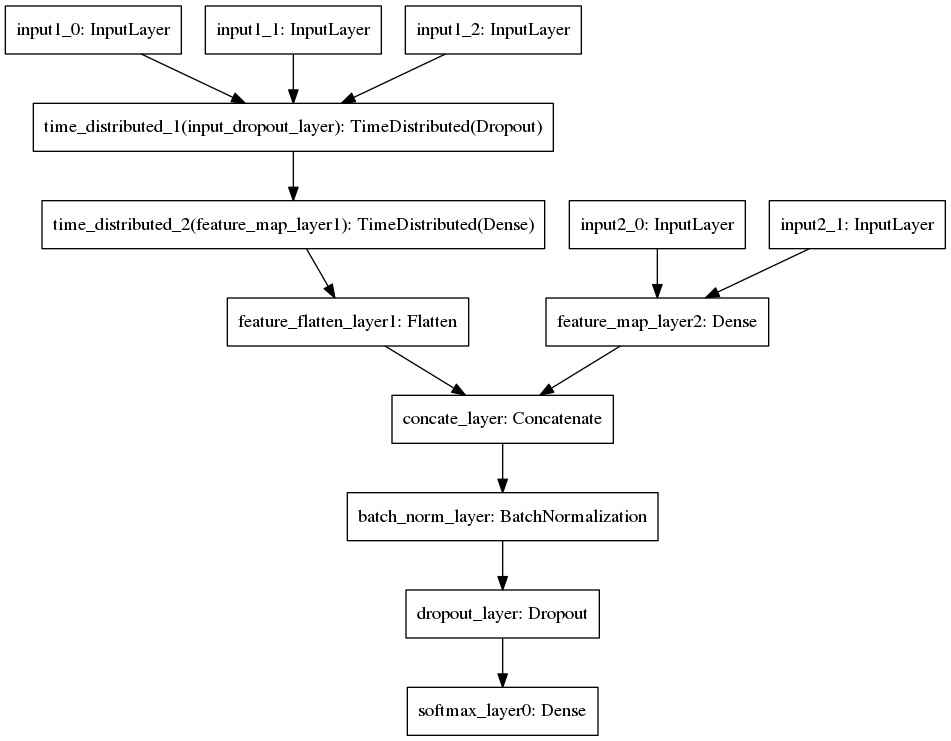

In [33]:
from PIL import Image
img = Image.open('model.png')
display(img)

### Train Model

In [34]:
adam = ko.Nadam()
model.compile(adam, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

file_path = "best_mlp_model.hdf5"
check_point = kc.ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1, save_best_only = True, mode = "min")
early_stop = kc.EarlyStopping(monitor = "val_loss", mode = "min", patience=3)
history = model.fit(X_train, y_tra, batch_size=20, epochs=20, validation_data=(X_dev, y_dev), callbacks = [check_point, early_stop])

histories.append(np.min(np.asarray(history.history['val_loss'])))

# del model, history
gc.collect()


Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 454 samples
Epoch 1/20
2000/2000 [==============================] - 6s 3ms/step - loss: 1.4625 - sparse_categorical_accuracy: 0.4365 - val_loss: 0.9685 - val_sparse_categorical_accuracy: 0.5617

Epoch 00001: val_loss improved from inf to 0.96851, saving model to best_mlp_model.hdf5
Epoch 2/20
2000/2000 [==============================] - 1s 409us/step - loss: 1.0472 - sparse_categorical_accuracy: 0.5560 - val_loss: 0.8896 - val_sparse_categorical_accuracy: 0.6101

Epoch 00002: val_loss improved from 0.96851 to 0.88964, saving model to best_mlp_model.hdf5
Epoch 3/20
2000/2000 [==============================] - 1s 408us/step - loss: 0.9083 - sparse_categorical_accuracy: 0.6030 - val_loss: 0.8414 - val_sparse_categorical_accuracy: 0.6256

Epoch 00003: val_loss improved from 0.88964 to 0.84136, saving model to best_mlp_model.hdf5
Epoch 4/20
2000/2000 [==============================] - 1s 411us/step - loss: 0.

40

In [ ]:
history.history['val_sparse_categorical_accuracy']

In [35]:
loss, score = model.evaluate(x=X_test, y=y_test)
print('model evalutation loss = {} and score = {}'.format(loss, score))

2000/2000 [==============================] - 0s 118us/step
model evalutation loss = 0.7349680013656616 and score = 0.6765


In [36]:

y_sub_preds = model.predict(X_sub_test, batch_size = 1024, verbose = 1)

sub_df_path = os.path.join(SUB_DATA_FOLDER, 'sample_submission_stage_2.csv')
sub_df = pd.read_csv(sub_df_path)
sub_df.loc[:, 'A'] = pd.Series(y_sub_preds[:, 0])
sub_df.loc[:, 'B'] = pd.Series(y_sub_preds[:, 1])
sub_df.loc[:, 'NEITHER'] = pd.Series(y_sub_preds[:, 2])

sub_df.head()
sub_df

12359/12359 [==============================] - 1s 93us/step


,ID,A,B,NEITHER
0,000075809a8e6b062f5fb3c191a8ed52,0.710623,0.227859,0.061518
1,0005d0f3b0a6c9ffbd31a48453029911,0.626769,0.344002,0.029229
2,0007775c40bedd4147a0573d66dc28f8,0.236517,0.756028,0.007455
3,001194e3fe1234d00198ef6bba4cc588,0.872655,0.099136,0.028210
4,0014bb7085278ef3f9b74f14771caca9,0.279160,0.534425,0.186415
5,002671a4f3ec8d724e0541c2f1a1f8cc,0.902773,0.079135,0.018092
6,002eb2ad27bbeab286b15650b8cb2c27,0.873924,0.121330,0.004746
7,002eebd91abbd53207da15ae61714531,0.185972,0.793674,0.020354
8,0034d8a107da2eeba335128665f6fc1f,0.636728,0.356895,0.006377
9,0034dfd350220409b621a5e3ac1c5e02,0.115709,0.645617,0.238674


In [37]:
sub_df.to_csv("submission.csv", index=False)